In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from math import *
from scipy.signal import argrelextrema

import networkx as nx

import seaborn as sns
sns.set()
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 4.0})

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from flowme import *

In [4]:
def getDotE_con_new_DIAG(B1, B2, w, e, eps, k, thr, alph, mu):
    matmask = np.logical_not(np.abs(np.sqrt(w)+e*eps) < thr)
    PE = np.multiply(e, matmask)

    L1_E = HodgeLW_fr(B1, B2, w, e, eps)
    vals, vecs=np.linalg.eigh(L1_E)
    idx = vals.argsort() 
    vals = vals[idx]
    vecs=vecs[:, idx]
    
    GE = np.zeros(L1_E.shape[0])
    for i in range(k+1):
        Gi=np.diag(getG_i(B1, B2, L1_E, vecs[:,i], w, e, eps))
        GE = GE + Gi;
    
    L0=getL0(B1, w, e, eps)
    W=np.diag(np.sqrt(w)+eps*e)
    D12=np.diag(np.power(np.sum(np.abs(B1) @ W, 1), -1))
    vals, vecs=np.linalg.eigh(L0)
    idx = vals.argsort() 
    vals = vals[idx]
    x=vecs[:, 1].reshape(-1, 1)
    if vals[1]<mu:
        Add = np.diag(2.*B1.T @ D12 @ (x @ x.T) @ D12 @ B1 @ W - 2.*np.diag(np.diag(Sym(D12 @ (x @ x.T) @ L0)).reshape(-1, 1).T @ np.abs(B1)))
        GE = GE - alph/mu*np.max([0, 1-vals[1]/mu])*Add
    
    
    kappa = np.sum(np.multiply(GE, PE))/np.sum(np.multiply(PE, PE))
    PGE = np.multiply(GE, matmask)
    dE = -PGE+kappa*PE
    return dE


In [5]:
edges=readEdges('/Users/mryodo/.CMVolumes/mryodo/work/gssi/graph.control/control.graph/python/gr.flow/6.edges')
trigs=readTrigs('/Users/mryodo/.CMVolumes/mryodo/work/gssi/graph.control/control.graph/python/gr.flow/6.trigs')

n=7
B1=B1fromEdges(n, edges)
B2=B2fromTrig(n, edges, trigs)
w=getRandomWeights(edges)


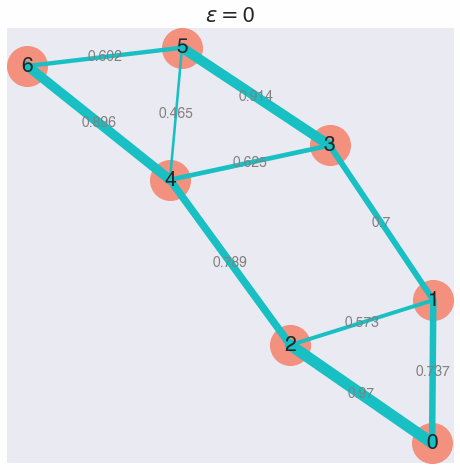

In [6]:
thr=1e-8
L1=HodgeLW_fr(B1, B2, w, 0, 0)
L0=getL0(B1, w, 0, 0)
tmp=np.sort(np.linalg.eig(L0)[0])
mu=tmp[1]*0.9
#w=[1.01 1.02 .99 0.98 1.08 1.05 0.95 0.25 1.1 0.99]';

points=getPosFromB1(B1)
simpleDrawB1(B1, w, points, edges, 0, 0)



In [7]:
eps=0
e=np.ones(w.shape)
e=e/np.linalg.norm(e)
e=getDotE_con_new_DIAG(B1, B2, w, e, eps, k, thr, alpha, mu)
e=e/np.linalg.norm(e)

In [70]:
e

array([ 0.1069737 ,  0.17882919,  0.27631713, -0.4907354 , -0.71215865,
        0.2425976 ,  0.059673  ,  0.22093604, -0.0251692 ,  0.14273658])

In [8]:
k=1
alpha=10.0
h=1e-1
beta=1.2
thr=1e-12

mu=tmp[1]*0.95

In [62]:
h=1e-2

eps=0
e=np.ones(w.shape)
#e=e/np.linalg.norm(e)
#e=getDotE_con_new_DIAG(B1, B2, w, e, eps, k, thr, alpha, mu)
e=-e/np.linalg.norm(e)

eps=np.sqrt(w[7])
print("initial setup done")
L1_E = HodgeLW_fr(B1, B2, w, e, eps)
L0=getL0(B1, w, e, eps)
track = [getFk_l2_con_new(L1_E, k, L0, alpha, mu)]

t_cur = 0
log = []
ts = [0]
h0=h
tfin=1000
nu=1.0
i=0
fl=False
minval=1.0
emin=np.zeros(e.shape)

h_log=[]
h_desc=[]

while  (i<=10000) :
    i+=1
    #if i % 100 ==0:
    #    print(i, end=' ')
    e0 = e
    dE = getDotE_con_new_DIAG(B1, B2, w, e, eps, k, thr, alpha, mu)
    while True:
        e1 = e-h*dE
        e1[np.sqrt(w)+eps*e1<0]=-1./eps*np.sqrt(w)[np.sqrt(w)+eps*e1<0]
        if np.sum(np.sqrt(w)+eps*e1<0)>0:
            print(np.sum(np.sqrt(w)+eps*e1<0))
        e1=e1/np.linalg.norm(e1)
        L1_E = HodgeLW_fr(B1, B2, w, e1, eps)
        L0=getL0(B1, w, e1, eps)
        newval=getFk_l2_con_new(L1_E, k, L0, alpha, mu)
       
        if  (newval <= track[-1]):
            #fl = ( (track[-1]-newval) <= (h*1e-5*track[-1]+1e-8) )
            #print(i, '/ step ', h, ' accepted')
            h=h*beta
            h_log.append(h)
            h_desc.append(1)
            e = e1
            break
        else:
            e = e0
            #print(i, '/ step ', h, ' rejected')
            h = h/beta 
            h_log.append(h)
            h_desc.append(2)
        if h<1e-9:
            #e = e+nu/(i+1)*(np.random.uniform(size=(e.shape[0]))*2-1)
            e=e+nu*getDotE_con_new_DIAG(B1, B2, w, e, 0, k, thr, alpha, mu)
            e[np.sqrt(w)+eps*e<0]=-np.sqrt(w)[np.sqrt(w)+eps*e<0]/eps
            e=e/np.linalg.norm(e)

            L1_E = HodgeLW_fr(B1, B2, w, e1, eps)
            L0=getL0(B1, w, e1, eps)
            newval=getFk_l2_con_new(L1_E, k, L0, alpha, mu)

            h=h0
            h_log.append(h)
            h_desc.append(3)
            break
    
    log.append(np.sort(np.linalg.eigvals(L1_E)))
    track.append(newval)
    if track[-1]<minval:
        minval=track[-1]
        emin=e
    t_cur =t_cur + h
    ts.append(t_cur)

track=np.array(track)
log=np.array(log)
h_log=np.array(h_log)
h_desc=np.array(h_desc)

initial setup done


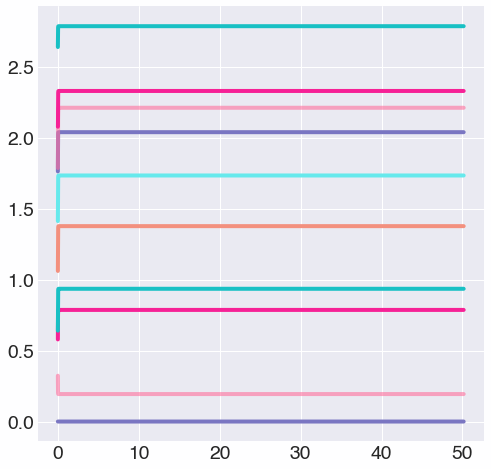

In [64]:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

for i in range(log.shape[1]):
    ax.plot(ts[1:], log[:, i])


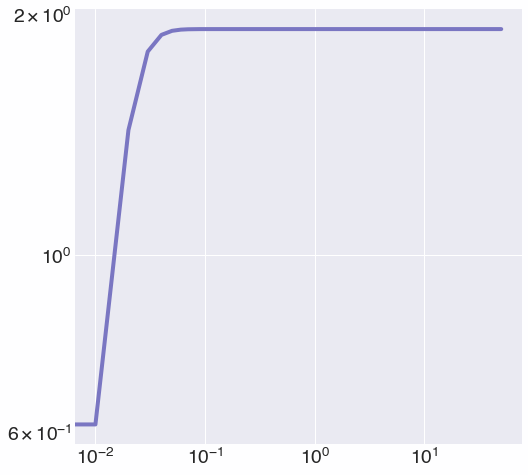

In [65]:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(ts, track, color=colors[0])
ax.set_xscale('log')
ax.set_yscale('log')

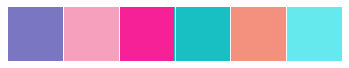

In [57]:
sns.palplot(colors)

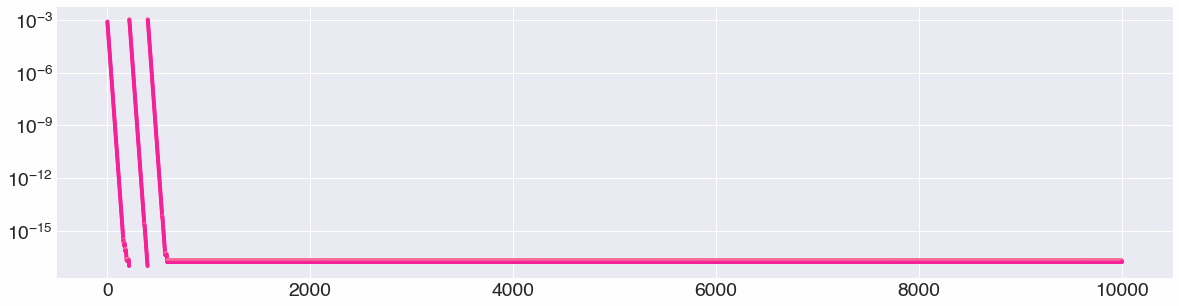

In [47]:
fig=plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.scatter(np.arange(0, 10000), h_log[:10000], c=np.array(colors)[h_desc][:10000], marker='.')
#for i in range(h_log.shape[0]):
#    ax.plot([i,i], [0, h_log[i]], color=colors[h_desc[i-1]])
ax.set_yscale('log')


In [48]:
-dE

array([0.30433247, 0.22369228, 0.06757117, 0.23825336, 0.25005901,
       0.07182019, 0.28970239, 0.24627986, 0.37107356, 0.05760995])

In [101]:
np.min(h_log)


2.2463089174695173e-18

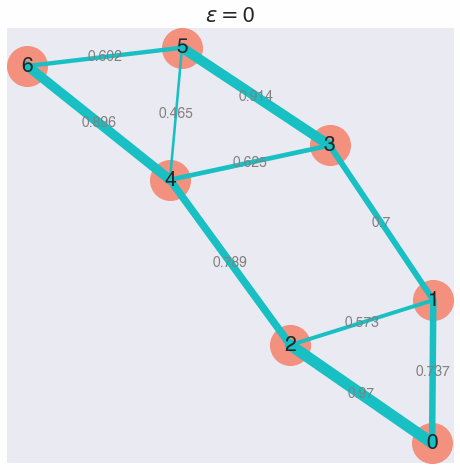

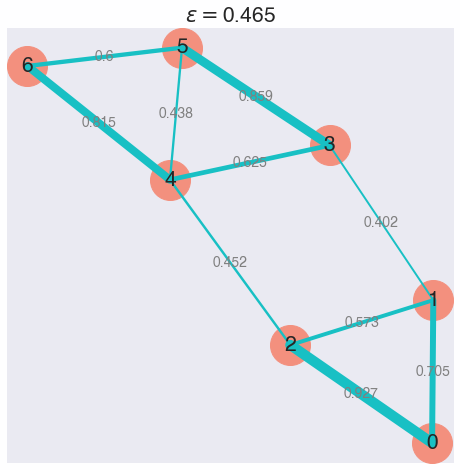

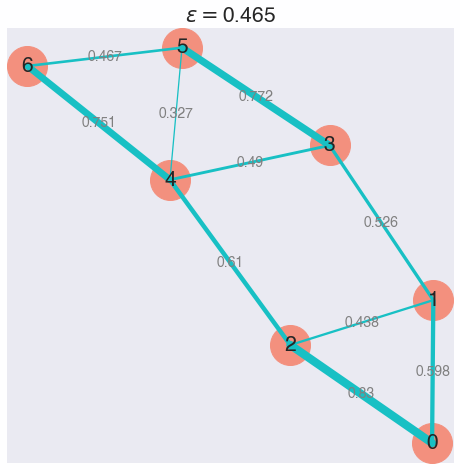

In [58]:

simpleDrawB1(B1, w, points, edges, 0, 0)
simpleDrawB1(B1, w, points, edges, eps, e)
simpleDrawB1(B1, w, points, edges, eps, emin)

In [55]:
track

array([2.99074119, 2.99074119, 2.99074119, ..., 2.99074119, 2.99074119,
       2.99074119])

In [86]:
h_desc[-100:]

array([2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1])

In [4]:
alpha=1.0
k=1
h=1e-1
beta=1.2
thr=1e-12

eps=1e-100
e=np.ones(w.shape)
e=e/np.linalg.norm(e)
dE, GE=getDotE_con_new(B1, B2, w, e, eps, k, thr, alpha, mu)
e=np.diag(dE)
e=-e/np.linalg.norm(e)

eps=np.sqrt(w[-2])
print("initial setup done")


L1_E = HodgeLW_fr(B1, B2, w, e, eps)
E1=np.diag(e)
L0=getL0(B1, w, e, eps)
track = [getFk_l2_con_new(L1_E, k, L0, alpha, mu)]
t_cur = 0
log = []
ts = [0]
h0=h
tfin=1000
nu=0.2
i=0
fl=0
minval=1.0
emin=np.zeros(e.shape)
while (ts[-1]<tfin) and (i<=1000) :
    i+=1
    print(i, end=' ')
    e0 = e
    dE, GE = getDotE_con_new(B1, B2, w, e, eps, k, thr, alpha, mu)
    #print(scal(E1, dE), np.sqrt(scal(dE, dE)), scal(GE, dE))
    fl=0
    while True and (fl==0):
        st=0
        
        while True:
            e = e0
            
            E1 = np.diag(e)-h*dE
            e = np.diag(E1)
            e = e/np.linalg.norm(e)
            result=np.sqrt(w)+eps*e
            if np.sum(result < 0) > 0:
                e[result<0]=-np.sqrt(w)[result<0]/eps+thr
                break
            else:
                break
        newval=0
        if fl==0:
            L1_E = HodgeLW_fr(B1, B2, w, e, eps)
            L0=getL0(B1, w, e, eps)
            newval=getFk_l2_con_new(L1_E, k, L0, alpha, mu)
        if  (newval < track[-1]) and (fl==0):
            h = h*beta
            break
        else:
            h = h/beta 
        if (h<1e-9) and (fl==1):
            h=h0
            check=0
            C=1
            while check==0:
                e = np.diag(E1)+C*nu/np.log(i+1)*(np.random.uniform(size=(e.shape[0]))*2-1)
                e = e/np.linalg.norm(e)
                if np.sum(np.sqrt(w)+eps*e<0)>0:
                    print('!', end=' ')
                    e[np.sqrt(w)+eps*e<0]=1e-20-np.sqrt(w)[np.sqrt(w)+eps*e<0]/eps
                    e=e/np.linalg.norm(e)
                    check=1
                else:
                    check=1
                    #print('x', end=' ')
                    #C=C/2
            break
    log.append(np.sort(np.linalg.eigvals(L1_E)))
    track.append(newval)
    if track[-1]<minval:
        minval=track[-1]
        emin=e
    t_cur =t_cur + h
    ts.append(t_cur)


initial setup done
1 2.6020852139652106e-18 0.06517984203489295 -0.004248411807693599
2 2.6020852139652106e-18 0.0651798420348931 -0.004248411807693617


KeyboardInterrupt: 

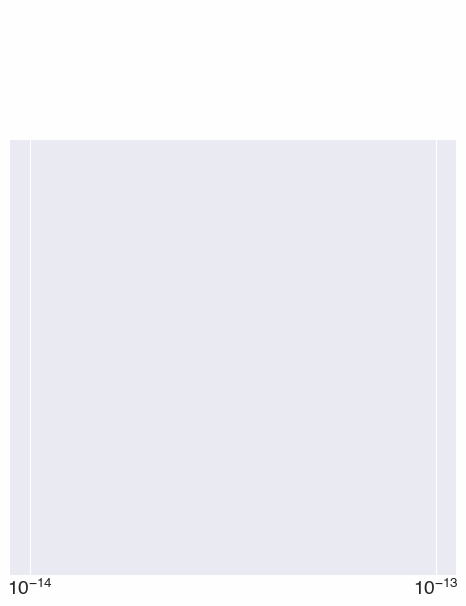

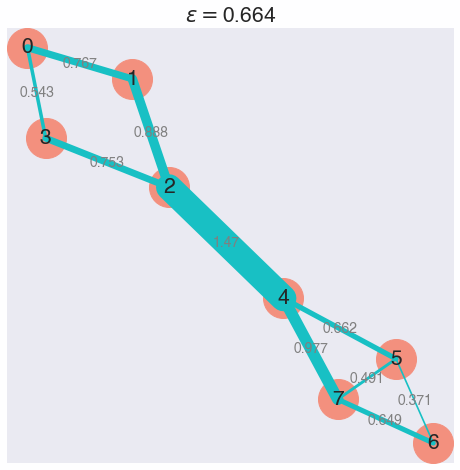

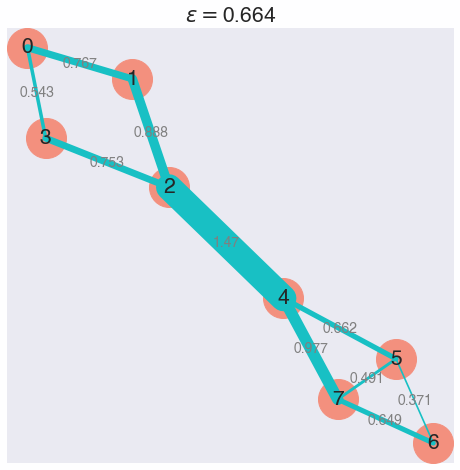

In [5]:
plt.figure(figsize=(8,8))
plt.loglog(ts, track, color=colors[0])

simpleDrawB1(B1, w, points, edges, eps, e)
simpleDrawB1(B1, w, points, edges, eps, emin)

In [9]:
scal(dE, np.diag(GE))

ValueError: diag requires an array of at least two dimensions

In [14]:
scal(np.diag(np.diag(GE)), dE)

-0.004248411807693617